# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 1B: Basic Concepts III

This notebook begins by exploring functions in GT4Py.

We first import the necessary packages as before.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gt4py
import gt4py.storage as gt_storage
from gt4py import gtscript
from gt4py.gtscript import Field 

from tools import plot_two_ij_slices, run_stencil_scaling, plot_scaling_data

### Define the 2D Laplacian stencil:

In [9]:
def laplacian_def(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

### Domain Specification

Specify the initial domain sizes: (*n<sub>i</sub>*, *n<sub>j</sub>*, *n<sub>k</sub>*), the number of halo lines in *x* and *y*, *n<sub>halo</sub>*.

In [10]:
ni, nj, nk = 24, 24, 80
nhalo = 3

### Inspect the Generated Code

The generated filename for the target backend can be read directly from the stencil object as illustrated below.

In [11]:
@gtscript.stencil("debug")
def laplacian_def(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    (Hint: Make sure that when you modify code you retain the original code by commenting it out so that you undo any of the modifications you do.)
    <ol>
        <li style="margin-bottom: 10px">Extend the <code>laplacian</code> stencil to be a laplacian(laplacian(*)) by introducing a temporary field.</li>
        <li style="margin-bottom: 10px">Replace the redundant code with <code>gtscript.function</code>.</li>
        <li style="margin-bottom: 10px">Try removing the temporary field and calling the function in a nested manner.</li>
        <li style="margin-bottom: 10px">Implement the stencil with two functions, with the first calling the second.</li>
    </ol>
</div>

In [2]:
# SOLUTION 1:
@gtscript.stencil(backend="numpy")
def diffusion_def1(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    with computation(PARALLEL), interval(...):
        tmp_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = coeff * (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])

In [3]:
# SOLUTION 2:
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float = 1.0):
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + 
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.stencil(backend="numpy")
def diffusion_def2(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    with computation(PARALLEL), interval(...):
        tmp_field = laplacian(in_field, coeff)
        out_field = laplacian(tmp_field, coeff)

### No Nested Function Calls

This example demonstrates that nested function calls are not currently supported.

In [14]:
# SOLUTION 3:
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float = 1.0):
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + 
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.stencil(backend="numpy")
def diffusion_def3(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    with computation(PARALLEL), interval(...):        
        out_field = laplacian(laplacian(in_field))

GTScriptSyntaxError: Function calls are not supported in arguments to function calls

### Functions Calling Functions

This example demonstrates that functions can call other functions.

In [15]:
# SOLUTION 4:
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float = 1.0):
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + z
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.function
def double_lap(in_field: Field[np.float], coeff: np.float = 1.0):
    tmp_field = laplacian(in_field, coeff)
    return laplacian(tmp_field, coeff)

@gtscript.stencil(backend="numpy")
def diffusion_def4(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    with computation(PARALLEL), interval(...):        
        out_field = double_lap(in_field)

### Return Statements Required

Now let us demonstrate that return values are *NOT* optional...

In [33]:
# SOLUTION 5:
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float = 1.0):
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + 
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.function
def double_lap(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    tmp_field = laplacian(in_field, coeff)
    out_field = laplacian(tmp_field, coeff)

@gtscript.stencil(backend="numpy")
def diffusion_def5(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    with computation(PARALLEL), interval(...):        
        double_lap(in_field, out_field)

RecursionError: maximum recursion depth exceeded while calling a Python object

### No Recursive Functions

This example illustrates the lack of support for recursive functions.

In [17]:
# SOLUTION 6:     
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float = 1.0, depth: np.int = 0):
    if depth == 0:
        tmp_field = 0.0
        return laplacian(tmp_field, coeff, 1)
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + 
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.stencil(backend="numpy")
def diffusion_def6(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    with computation(PARALLEL), interval(...):        
        out_field = laplacian(in_field, coeff, 0)

GTScriptSyntaxError: Invalid call signature

### Offsets Allowed

This example demonstrates the ability to pass offsets to functions with offsets of their own.

In [18]:
# SOLUTION 7:
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float = 1.0):
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + 
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.stencil(backend="debug")
def lap_average(in_field: Field[np.float], out_field: Field[np.float], coeff: np.float = 1.0):
    with computation(PARALLEL), interval(...):        
        out_field = (laplacian(in_field) + laplacian(in_field[1, 0, 0]) +
                     laplacian(in_field[-1, 0, 0])) * (1. / 3.)

In [19]:
file_name = gtscript.stencil("debug", lap_average)._file_name
!pygmentize $file_name

import time

import numpy as np
from numpy import dtype
from typing import Dict

import math


from gt4py.stencil_object import AccessKind, Boundary, DomainInfo, FieldInfo, ParameterInfo, StencilObject


class _Accessor:
    def __init__(self, array, origin):
        self.array = array
        self.origin = origin

    def _shift(self, index):
        return tuple(i + offset for i, offset in zip(index, self.origin))

    def __getitem__(self, index):
        return self.array[self._shift(index)]

    def __setitem__(self, index, value):
        self.array[self._shift(index)] = value


class lap_average____debug_6af6b4a96d(StencilObject):
    """


    Default Parameters
    ------------------
    domain : `Sequence` of `int`, optional
        Shape of the computation domain. If `None`, it will be used the
        largest feasible domain according to the provided input fields
        and origin values (`None` by default).

    origin :  `[int * ndims]` or `{'field_name': [int * ndims]}`

### Function Arguments are Immutable

This example demonstrates that function inputs cannot be modified, i.e., these are pure functions.

In [20]:
@gtscript.function
def gemm(a: Field[np.float], b: Field[np.float], c: Field[np.float],
         alpha: np.float = 1.0, beta: np.float = 1.0):
    c = alpha * a * b + beta * c
    return c

@gtscript.stencil(backend="numpy")
def gemm_def(a: Field[np.float], b: Field[np.float], c: Field[np.float],
             alpha: np.float = 1.0, beta: np.float = 1.0):
    with computation(PARALLEL), interval(...):        
        c = gemm(a, b, c, alpha, beta)

### Complex Input Expressions

The following example demonstrates that function inputs can be an expression composed of fields, scalars, constants and math functions.

In [21]:
@gtscript.function
def field_sum(a: Field[np.float], b: Field[np.float]):
    return a + b

@gtscript.stencil(backend="numpy")
def func_exprs(a: Field[np.float], b: Field[np.float], c: Field[np.float],
             alpha: np.float = 1.0, beta: np.float = 1.0):
    with computation(PARALLEL), interval(...):        
        c = field_sum(alpha * (a * b), (beta * abs(c)) / 2.0)

### Limited Call Stack

This example demonstrates that the call depth of GT4Py functions is limited to 6.

In [23]:
@gtscript.function
def add1(a: Field[np.float]):
    a += 1
    return a

@gtscript.function
def add2(a: Field[np.float]):
    a += add1(a) + 1
    return a

@gtscript.function
def add3(a: Field[np.float]):
    a += add2(a) + 1
    return a

@gtscript.function
def add4(a: Field[np.float]):
    a += add3(a) + 1
    return a

@gtscript.function
def add5(a: Field[np.float]):
    a += add4(a) + 1
    return a

@gtscript.function
def add6(a: Field[np.float]):
    a += add5(a) + 1
    return a

@gtscript.function
def add7(a: Field[np.float]):    
    a += add6(a) + 1

@gtscript.function
def adds(a: Field[np.float]):    
    return add7(a)

@gtscript.stencil(backend="numpy")
def adds_def(a: Field[np.float]):
    with computation(PARALLEL), interval(...):        
        a = adds(a)

### Demonstrate zero-overhead of `gtscript.function`'s

During the presentation for this session, the claim was made that `gt4py` functions have zero overhead because the function statements are automatically inlined. Now let us test that assertion using the diffusion code written in the previous exercise.

In [4]:
ni, nj, nk = 24, 24, 80
nhalo = 3
timings1, sizes1 = run_stencil_scaling(diffusion_def1, ["numpy", "gtmc"], (ni, nj, nk), (nhalo, nhalo, 0))
timings2, sizes2 = run_stencil_scaling(diffusion_def2, ["numpy", "gtmc"], (ni, nj, nk), (nhalo, nhalo, 0))

both_timings = {}
both_sizes = {}
for backend in timings1.keys():    
    both_timings[f"{backend}_inline"] = timings1[backend]
    both_timings[f"{backend}_func"] = timings2[backend]
    both_sizes[f"{backend}_inline"] = sizes1[backend]
    both_sizes[f"{backend}_func"] = sizes2[backend]

Running with numpy backend (0)...
Running with numpy backend (1)...
Running with numpy backend (2)...
Running with numpy backend (3)...
Running with numpy backend (4)...
Running with gtmc backend (0)...
Running with gtmc backend (1)...
Running with gtmc backend (2)...
Running with gtmc backend (3)...
Running with gtmc backend (4)...
Running with numpy backend (0)...
Running with numpy backend (1)...
Running with numpy backend (2)...
Running with numpy backend (3)...
Running with numpy backend (4)...
Running with gtmc backend (0)...
Running with gtmc backend (1)...
Running with gtmc backend (2)...
Running with gtmc backend (3)...
Running with gtmc backend (4)...


In [ ]:
plot_scaling_data(both_timings, both_sizes)

### Forward and Backward Loops

Forward and backward loops are useful for implementing stencils with loop carried dependencies in the *k*-direction. These are loops that cannot be executed in parallel due to race conditions. One common application of forward and backward loops is the tridiagonal solver pattern.

A tridiagonal matrix solver is a simplified version of Gaussian elimination for tridiagonal systems of equations using the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm).

![Tridiagonal Matrix](https://wikimedia.org/api/rest_v1/media/math/render/svg/66abee37b2bc74f82fb79e7e1f0b5475be9f9632)

The following cell contains an implementation of the algorithm in GT4Py. The first stencil, `tridiag_matmul` computes the *d* field with a randomly generated, *x0*, as in this expression:

![Tridiagonal Multiplication](https://wikimedia.org/api/rest_v1/media/math/render/svg/2960afa763dced3c58f7ebd67c60b7a9efdc1e1d)

The second stencil, `tridiag_solve`, applies the Thomas algorithm to solve for *x1*. If successful, the plots of the two *x* fields will be identical (i.e, the same color).

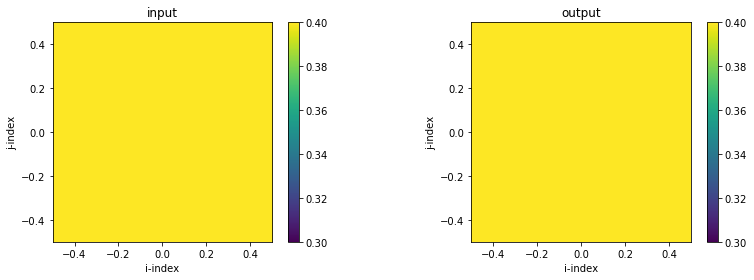

In [28]:
backend = "numpy"
dtype = np.float64
Field3D = Field[dtype]
nz = 1024

@gtscript.stencil(backend=backend)
def tridiag_matmul(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(PARALLEL):
        with interval(0, 1):
            d = b * x + c * x[0, 0, 1]
        with interval(1, -1):
            d = a * x[0, 0, -1] + b * x + c * x[0, 0, 1]
        with interval(-1, None):
            d = a * x[0, 0, -1] + b * x

@gtscript.stencil(backend=backend)
def tridiag_solve(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(FORWARD):
        with interval(1, None):
            w = a / b[0, 0, -1]
            b -= w * c[0, 0, -1]
            d -= w * d[0, 0, -1]
    with computation(BACKWARD):
        with interval(-1, None):
            x = d / b
        with interval(0, -1):
            x = (d - c * x[0, 0, 1]) / b


origin = (0, 0, 0)
shape = (1, 1, nz)
a = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
b = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
c = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
x0 = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
d = gt_storage.zeros(backend, origin, shape, dtype=dtype)
x1 = gt_storage.zeros(backend, origin, shape, dtype=dtype)

tridiag_matmul(a, b, c, d, x0)
tridiag_solve(a, b, c, d, x1)

plot_two_ij_slices(x0, x1)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px">Implement the Fibonacci sequence in GT4Py using a <tt>FORWARD</tt> loop.</li>
        <li style="margin-bottom: 10px">Change the loop order from <tt>FORWARD</tt> to <tt>BACKWARD</tt> and compare the results.</li>
        <li style="margin-bottom: 10px">Try again with the <tt>PARALLEL</tt> (default) loop order. What has changed? </li>
        <li style="margin-bottom: 10px">Create a parallel sum stencil </li>
    </ol>
</div>

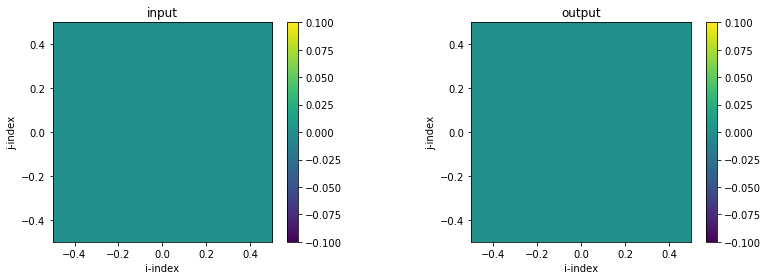

In [29]:
# SOLUTION 1
backend = "numpy"
dtype = np.float
FieldK = Field[dtype, gtscript.K]
nz = 64

@gtscript.stencil(backend=backend)
def fibonacci(fib: FieldK):
    with computation(FORWARD):
        with interval(1, 2):
            fib = 1.    # base case...
        with interval(2, None):
            fib = fib[0, 0, -2] + fib[0, 0, -1]
        

fib_gt = gt_storage.zeros(backend, (0, 0, 0), (1, 1, nz), dtype)
fibonacci(fib_gt, origin=(0, 0, 0), domain=(1, 1, nz))

n = np.arange(0, nz)
sqrt5 = np.sqrt(5.)
phi = (1. + sqrt5) / 2.
fib_data = np.rint((phi ** n - (-1. / phi) ** n) / sqrt5)
fib_np = gt_storage.from_array(fib_data, backend, (0, 0, 0), (1, 1, nz), dtype=dtype)

plot_two_ij_slices(fib_np, fib_gt)
# fib_gt

### Parallel Sum

Implement a parallel sum stencil that sums all of the *k*-values for a 3D field into a single *i*-*j* plane represented by a 2D field.

__Must use a <tt>GridTools</tt> backend!__

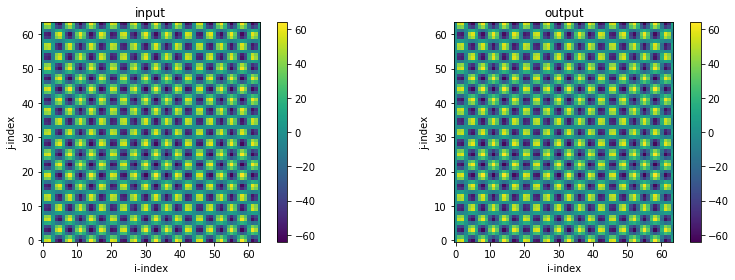

In [32]:
# SOLUTION 2
backend = "gtmc"
dtype = np.float64
Field3D = Field[dtype]
Field2D = Field[dtype, gtscript.IJ]
nz = 64

@gtscript.stencil(backend=backend)
def parallel_sum(nums: Field3D, sums: Field2D):
    with computation(PARALLEL), interval(...):
        sums += nums

# GT4Py version...
in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (nz, nz, nz), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (nz, nz, nz), dtype=dtype)  
sums_gt = gt_storage.zeros(backend, (0, 0, 0), (nz, nz, 1), dtype)

parallel_sum(nums, sums_gt, origin=(0, 0, 0), domain=(nz, nz, nz), validate_args=False)

# NumPy version...
sums_np = gt_storage.zeros(backend, (0, 0, 0), (nz, nz, 1), dtype=dtype)
sums_np[:, :, 0] = np.sum(nums, 2)

plot_two_ij_slices(sums_np, sums_gt)

### Parallel Count [REMOVE ME!]

Probably remove this example is it includes control flow, which will not be covered until Day 2...

In [102]:
backend = "gtmc"
dtype = np.float64
itype = np.int32
Field3D = Field[dtype]
IntField2D = Field[itype, gtscript.IJ]


@gtscript.stencil(backend=backend)
def parallel_count(nums: Field3D, counts: IntField2D):
    with computation(PARALLEL), interval(...):
        if nums > 0.0:
            counts += 1
        

in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (64, 64, 64), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (64, 64, 64), dtype=dtype)  
counts = gt_storage.zeros(backend, (0, 0, 0), (64, 64, 1), itype)

parallel_count(nums, counts, origin=(0, 0, 0), domain=(64, 64, 64), validate_args=False)

counts[:, :, 0]

CPUStorage([[ 0,  0,  0, ...,  0,  0,  0],
            [64, 64,  0, ...,  0, 64, 64],
            [64, 64,  0, ...,  0, 64, 64],
            ...,
            [ 0,  0, 64, ..., 64,  0,  0],
            [ 0,  0, 64, ..., 64,  0,  0],
            [64, 64,  0, ...,  0, 64, 64]], dtype=int32)